# Classes of Peaks based on ATAC signal

Can one define different classes of peaks based on the signal and the signal variation across cells?

Can one cluster CREs based on their ATAC-signal?

Can one visualize the behaviour of clustered regions?

Can one define cell lineage specific CRE clusters?

Are there differences between these cell-lineage specific CRE clusters? When and how long are they active?

### Import of Packages and Data Prep

In [3]:
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import sklearn.manifold as sklm
import os
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
import scanpy as sc
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import anndata as ad
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import igraph as ig
import leidenalg

import functions

importlib.reload(functions)
functions.set_user('Pia')

data = functions.call_data_clean(p_threshold=None)
ATAC = data['ATAC_seq']
ATAC_scores = data['norm_scores']
exons = data['exons']
ATACtest = data['test1']
ATAC_dis_path = "/Users/piakentschke/Documents/Uni/Data Analysis/ATAC_dis_annotated.csv"
ATAC_dis = pd.read_csv(ATAC_dis_path, index_col=0)
score_cols_all = list(data['norm_scores'].columns)
abgd = data['list_ATAC_Tc_ab_gd']
top2500 = data['top2500std']
QC = data['QC_metrics']

In [4]:
scores_TC = ATAC_scores[abgd]
scores_df = ATAC_scores.loc[top2500]

scores_df = ATAC_scores.copy()


### Peak Means and Variances

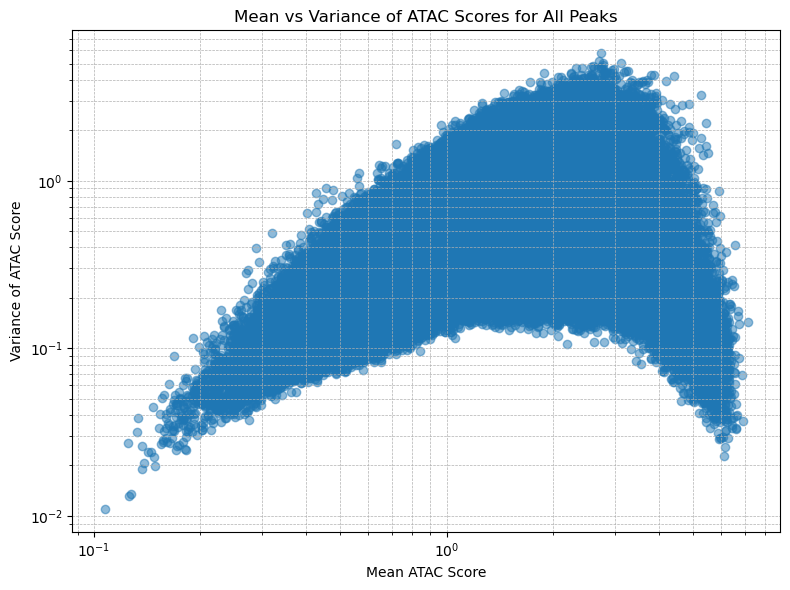

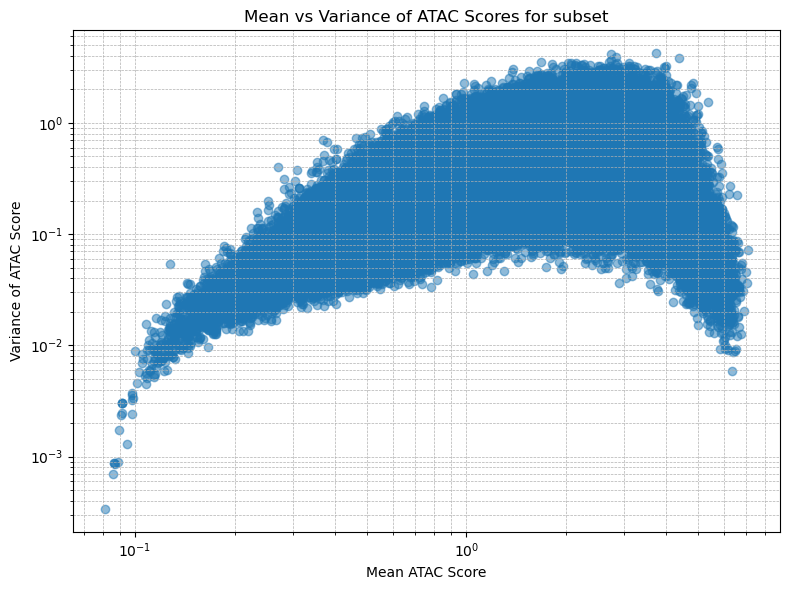

In [5]:
# calculate mean and variance of ATAC scores for each peak (and for the subset)

#full df
peak_means = ATAC_dis['mean']
peak_vars = ATAC_dis['var']
peak_stds = ATAC_dis['sd']
peak_cvs = peak_stds / peak_means

#subset df
peak_means_TC = scores_TC.mean(axis=1)
peak_vars_TC = scores_TC.var(axis=1)
peak_stds_TC = scores_TC.std(axis=1)
peak_cvs_TC = peak_stds_TC / peak_means_TC

# plot mean vs variance for all peaks
plt.figure(figsize=(8, 6))
plt.scatter(peak_means, peak_vars, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean ATAC Score')
plt.ylabel('Variance of ATAC Score')
plt.title('Mean vs Variance of ATAC Scores for All Peaks')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.figure(figsize=(8, 6))
plt.scatter(peak_means_TC, peak_vars_TC, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean ATAC Score')
plt.ylabel('Variance of ATAC Score')
plt.title('Mean vs Variance of ATAC Scores for subset')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


### Select Peaks to analyze

high mean --> high accessibility

high variance --> important for differentiation


In [6]:
#extract peaks with high variance (--> more significant for differentiation)
high_variance_peaks = ATAC_scores[peak_vars > 1]

high_variance_peaks_TC = scores_TC[peak_vars_TC > 1]

print(high_variance_peaks.shape)
print(high_variance_peaks_TC.shape)

(31251, 90)
(9627, 22)


## Peak Clustering

### Number of Clusters

In [7]:
# z-Scaling

# subset cells
scaled_TC = StandardScaler().fit_transform(high_variance_peaks_TC)

# all cells
scaled = StandardScaler().fit_transform(high_variance_peaks)

##### Elbow Method

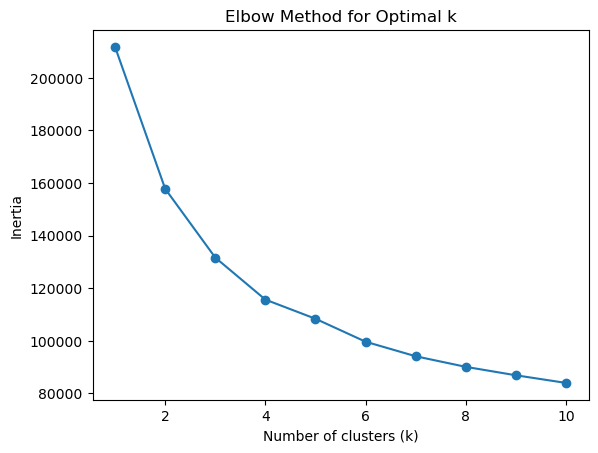

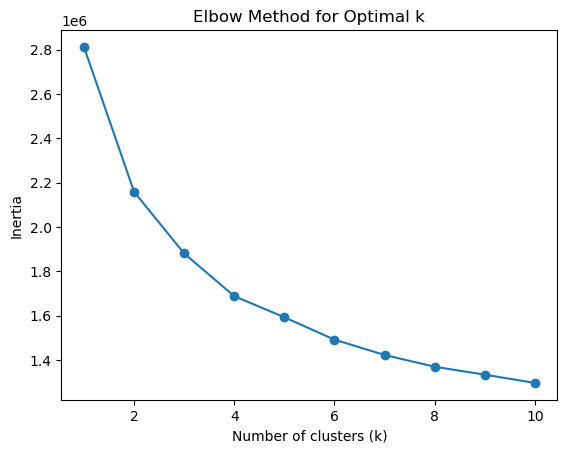

In [8]:
# subset
inertia = []
K_range = range(1, 11)


for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_TC)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# all cells
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

"elbow" at 2 clusters

##### Silhouette Score

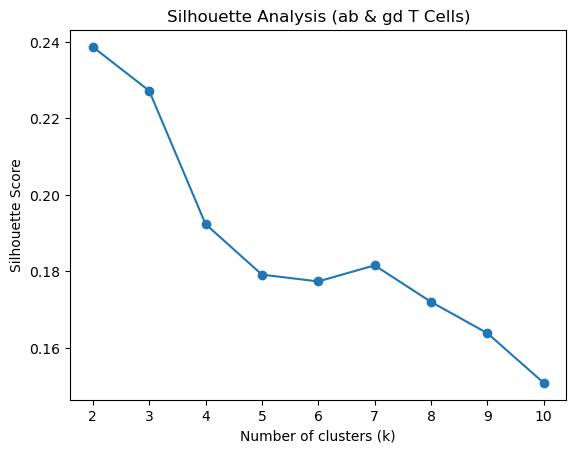

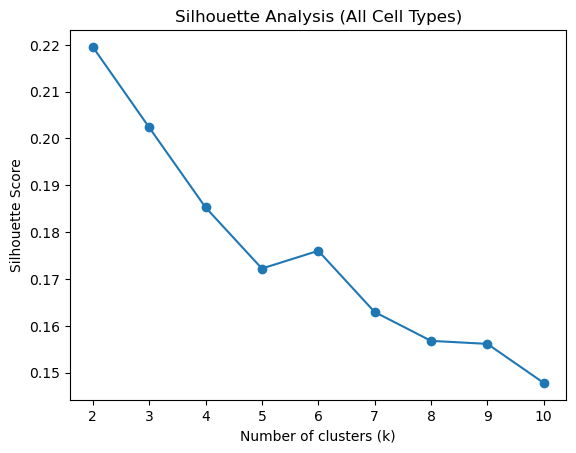

In [9]:
# subset
silscores_TC = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_TC = kmeans.fit_predict(scaled_TC)
    score_TC = silhouette_score(scaled_TC, labels_TC)
    silscores_TC.append(score_TC)

plt.plot(range(2, 11), silscores_TC, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis (ab & gd T Cells)')
plt.show()

# all cells
silscores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled)
    score = silhouette_score(scaled, labels)
    silscores.append(score)

plt.plot(range(2, 11), silscores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis (All Cell Types)')
plt.show()


highest silhouette score for 2 clusters

### Clustering and Heatmap

/var/folders/bb/wtz1qdn10sz99v6ltwmxxx0c0000gn/T/ipykernel_1551/1682927087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_variance_peaks_TC['cluster'] = kmeans.fit_predict(scaled_TC)


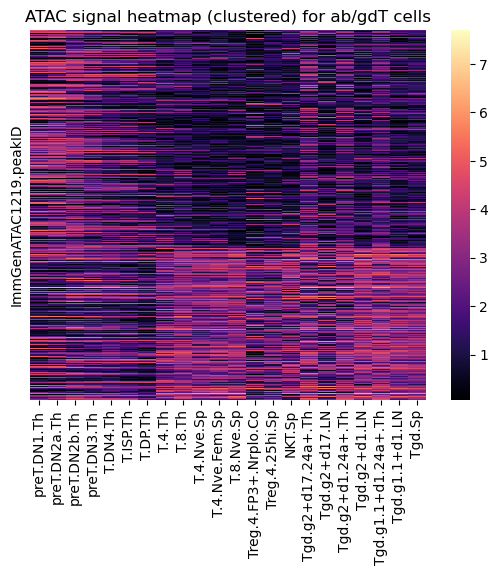

In [10]:
# subset
kmeans = KMeans(n_clusters=2, random_state=42)
high_variance_peaks_TC['cluster'] = kmeans.fit_predict(scaled_TC)

sorted_TC = high_variance_peaks_TC.sort_values('cluster')

sns.heatmap(sorted_TC.iloc[:, :-1], yticklabels=False, cmap='magma')
plt.title("ATAC signal heatmap (clustered) for ab/gdT cells")
plt.savefig("clustered_ATAC_peaks_TC.png", bbox_inches='tight')
plt.show()

cluster of peaks: 

0 --> more accessible in early differentiation,

1 --> more accessible in late differentiation


notable: some of the "early differentiation peaks" also active in d17.24a+ gdT cells

/var/folders/bb/wtz1qdn10sz99v6ltwmxxx0c0000gn/T/ipykernel_1551/3485912982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_variance_peaks['cluster'] = kmeans.fit_predict(scaled)


Text(0.5, 1.0, 'ATAC signal heatmap (clustered)')

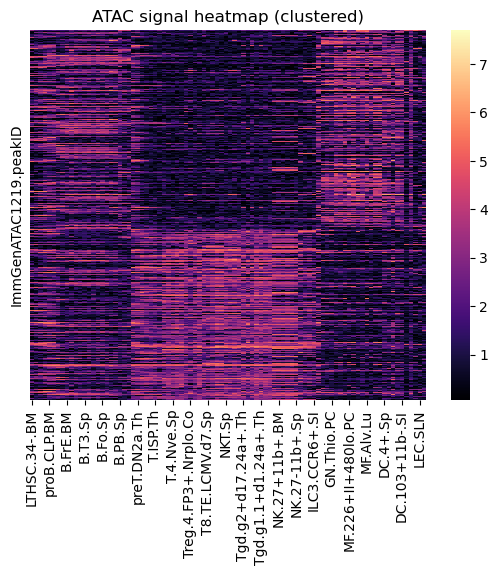

In [11]:
#all cells 
kmeans = KMeans(n_clusters=2, random_state=42)
high_variance_peaks['cluster'] = kmeans.fit_predict(scaled)

sorted_df = high_variance_peaks.sort_values('cluster')
sns.heatmap(sorted_df.iloc[:, :-1], yticklabels=False, cmap='magma')
plt.savefig("clustered_ATAC_peaks_all_cells.png", bbox_inches='tight')
plt.title("ATAC signal heatmap (clustered)")


peak clusters differ in accessibility in T and NK vs in other cells (Stem/Prog, myeloid etc.).

In [12]:
print("Peaks active in early differentiation of T cells:")
late_diff_peaks_TC = high_variance_peaks_TC[high_variance_peaks_TC['cluster'] == 0].index.tolist()
print(late_diff_peaks_TC)
print("Peaks active in late differentiation of T cells:")
early_diff_peaks_TC = high_variance_peaks_TC[high_variance_peaks_TC['cluster'] == 1].index.tolist()
print(early_diff_peaks_TC)

print("Peaks active in T and NK cells:")
peaks_TNK = high_variance_peaks[high_variance_peaks['cluster'] == 0].index.tolist()
print(peaks_TNK)
print("Peaks active in B, myeloid, Progenitor, Stem Cells, etc.")
peaks_other = high_variance_peaks[high_variance_peaks['cluster'] == 1].index.tolist()
print(peaks_other)

Peaks active in early differentiation of T cells:
['ImmGenATAC1219.peak_77', 'ImmGenATAC1219.peak_96', 'ImmGenATAC1219.peak_126', 'ImmGenATAC1219.peak_137', 'ImmGenATAC1219.peak_326', 'ImmGenATAC1219.peak_443', 'ImmGenATAC1219.peak_736', 'ImmGenATAC1219.peak_804', 'ImmGenATAC1219.peak_823', 'ImmGenATAC1219.peak_836', 'ImmGenATAC1219.peak_872', 'ImmGenATAC1219.peak_1062', 'ImmGenATAC1219.peak_1253', 'ImmGenATAC1219.peak_1255', 'ImmGenATAC1219.peak_1367', 'ImmGenATAC1219.peak_1388', 'ImmGenATAC1219.peak_1574', 'ImmGenATAC1219.peak_1662', 'ImmGenATAC1219.peak_1666', 'ImmGenATAC1219.peak_1926', 'ImmGenATAC1219.peak_1966', 'ImmGenATAC1219.peak_1969', 'ImmGenATAC1219.peak_2084', 'ImmGenATAC1219.peak_2086', 'ImmGenATAC1219.peak_2089', 'ImmGenATAC1219.peak_2090', 'ImmGenATAC1219.peak_2143', 'ImmGenATAC1219.peak_2165', 'ImmGenATAC1219.peak_2170', 'ImmGenATAC1219.peak_2272', 'ImmGenATAC1219.peak_2364', 'ImmGenATAC1219.peak_2415', 'ImmGenATAC1219.peak_3051', 'ImmGenATAC1219.peak_3056', 'ImmGenATA

In [13]:
# info dfs with respect to differentiation of T cells
info_early_diff_TC = ATAC_dis.loc[early_diff_peaks_TC]
info_late_diff_TC = ATAC_dis.loc[late_diff_peaks_TC]

## t-SNE and leiden Clustering of significant Peaks

#### t-SNE Dimension Reduction

In [14]:
print(list(ATAC_dis.columns))
score_cols_all = list(scores_df.columns)
print(score_cols_all)

score_cols_TC = abgd
print(score_cols_TC)

['chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27

#### all Cells

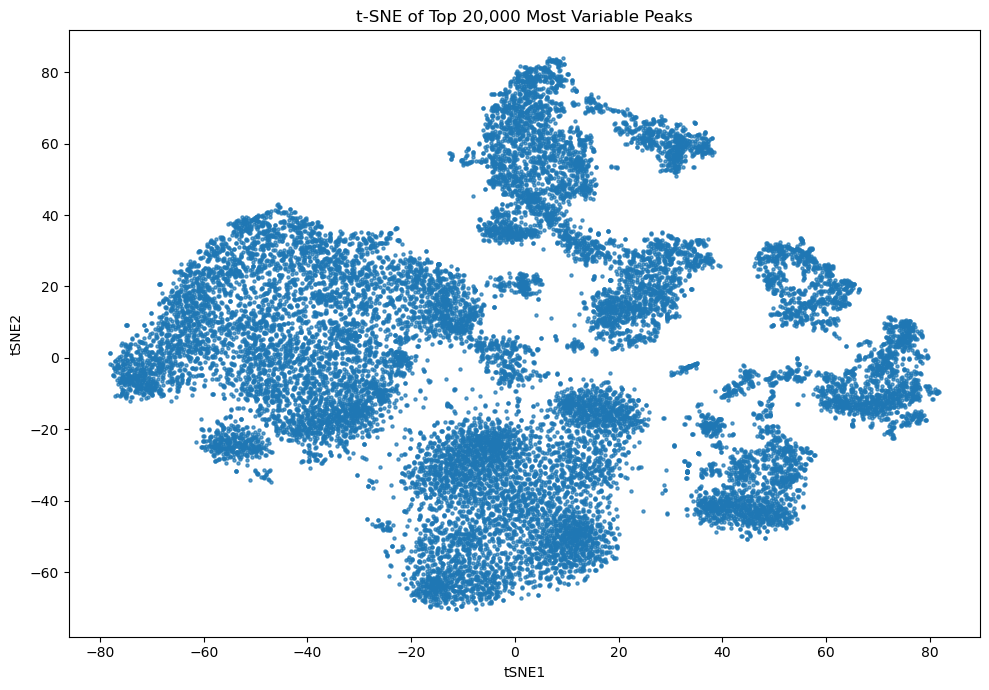

In [15]:
N = 20000

# only top variability peaks
top_peaks_idx = ATAC_dis['variability'].sort_values(ascending=False).head(N).index

# Subset: top N peaks and columns of interest
X = ATAC_dis.loc[top_peaks_idx, score_cols_all]

# Standardize (optional but helps)
X_scaled = StandardScaler().fit_transform(X)

# Run t-SNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
coords = tsne_model.fit_transform(X_scaled)

# Put into DataFrame
tsne_df = pd.DataFrame(coords, columns=['tSNE1', 'tSNE2'], index = top_peaks_idx)


plt.figure(figsize=(10, 7))
plt.scatter(tsne_df['tSNE1'], tsne_df['tSNE2'], s=5, alpha=0.7)
plt.title('t-SNE of Top 20,000 Most Variable Peaks')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.tight_layout()
plt.show()

#### dominant lineage per peak

In [16]:
scores_t = ATAC_scores.T

scores_t.index.name = 'CellType'

#subset qc dataframe to add only lineage, cell family and organ information
QC_subset = QC[['CellType', 'Lineage', 'CellFamily', 'Organ']].drop_duplicates(subset='CellType', keep='first').reset_index(drop=True)

#merge ATAC dataframe with QC subset, drop duplicate Celltype rows from QC and reset index (combined)
ATAC_w_info = scores_t.merge(QC_subset, on='CellType', how='left').reset_index(drop=True)

#print NaN rows
ATAC_w_info[ATAC_w_info.isna().any(axis=1)]

ATAC_w_info.at[85, 'CellFamily'] = 'Fibroblastic reticular cell'
ATAC_w_info.at[85, 'Lineage'] = 'stroma'
ATAC_w_info.at[85, 'Organ'] = 'skin draining Lymph Node'

celltype_to_lineage = QC.set_index('CellType')['Lineage']
lineages = celltype_to_lineage.unique()

# DataFrame mean per lineage
mean_per_lineage = pd.DataFrame(index=ATAC_dis.index)

for lin in lineages:
    celltypes = celltype_to_lineage[celltype_to_lineage == lin].index
    celltypes = [ct for ct in celltypes if ct in ATAC_scores.columns]
    mean_per_lineage[lin] = ATAC_dis[celltypes].mean(axis=1)

mean_per_lineage['dominant_lineage'] = mean_per_lineage.idxmax(axis=1)

#add dominant lineage to ATAC_dis
ATAC_dis['dominant_lineage'] = mean_per_lineage['dominant_lineage']

#display(ATAC_dis)

# coords --> DataFrame 
tsne_df = pd.DataFrame(coords, columns=['tSNE1', 'tSNE2'], index=top_peaks_idx)
tsne_df['dominant_lineage'] = ATAC_dis.loc[top_peaks_idx, 'dominant_lineage']

dominant_lineage = ATAC_dis.loc[top_peaks_idx, 'dominant_lineage']


### Leiden Clustering without PCA

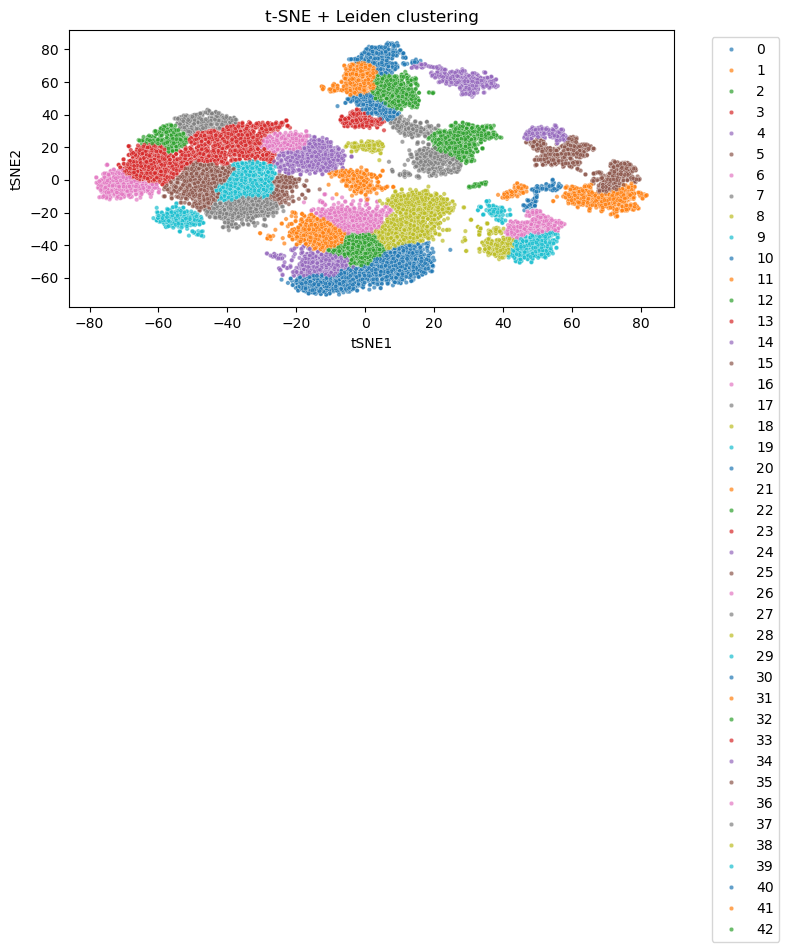

In [17]:
# kNN graph from t-SNE coordinates
k = 20
neighbors = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(tsne_df[['tSNE1', 'tSNE2']])
knn_graph = neighbors.kneighbors_graph(tsne_df[['tSNE1', 'tSNE2']], mode='connectivity')

# Convert kNN graph to igraph format
sources, targets = knn_graph.nonzero()
edges = list(zip(sources.tolist(), targets.tolist()))
g = ig.Graph(edges=edges, directed=False)
g.simplify()

partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, resolution_parameter=1.0)

# add cluster labels to t-SNE DataFrame
tsne_df['leiden_cluster'] = partition.membership

plt.figure(figsize=(8, 7))
sns.scatterplot(
    data=tsne_df,
    x='tSNE1', y='tSNE2',
    hue='leiden_cluster',
    palette='tab10',
    s=10, alpha=0.7
)
plt.title('t-SNE + Leiden clustering')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Clustering with PCA

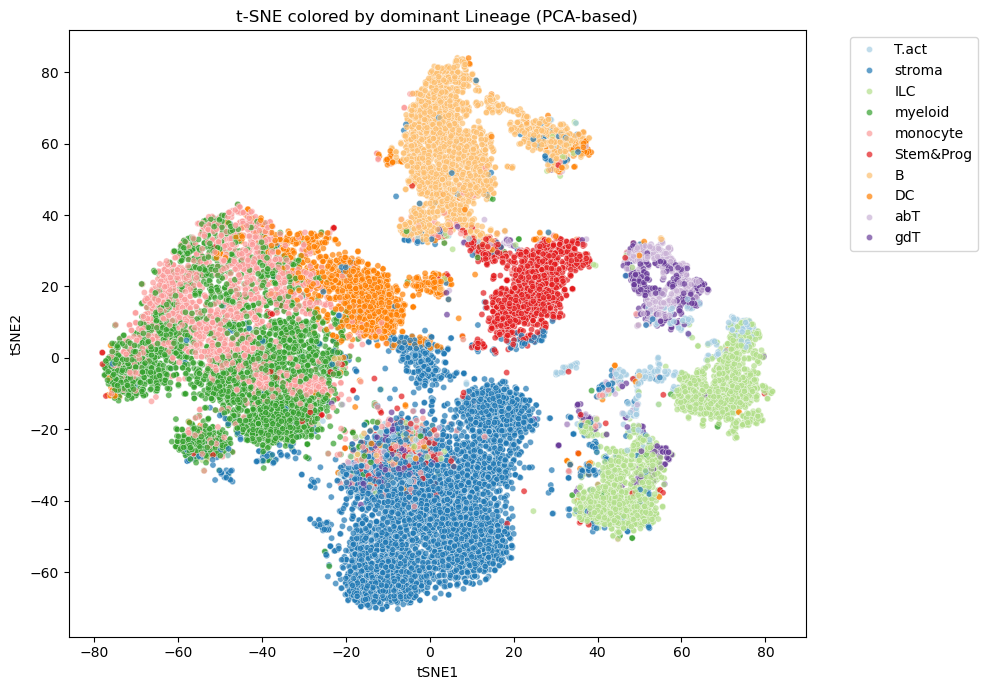

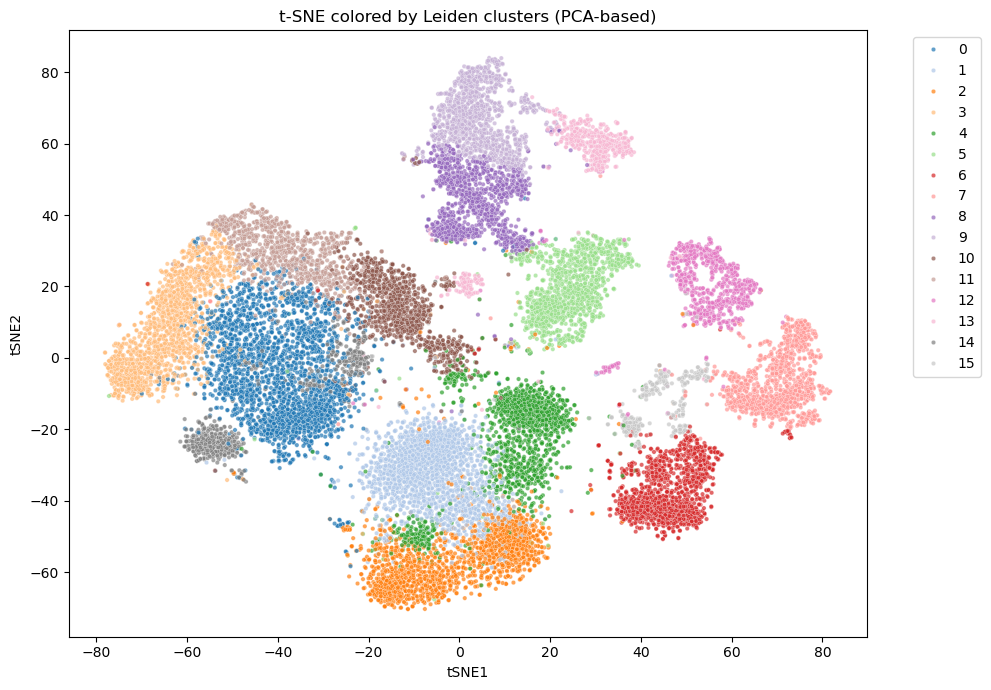

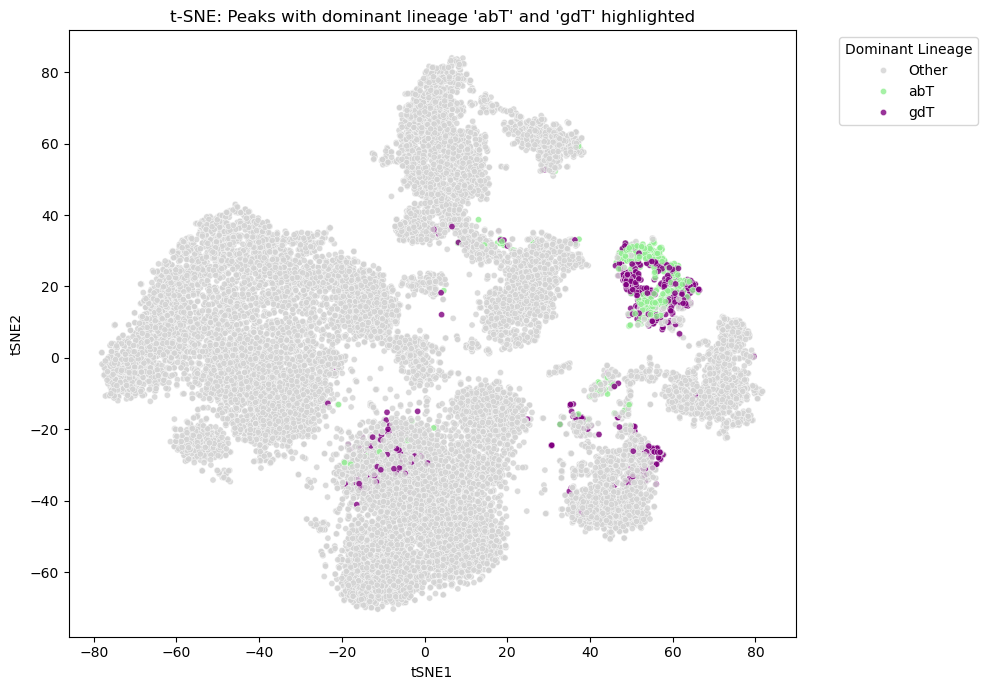

In [18]:
N = 20000

# only top variability peaks
top_peaks_idx = ATAC_dis['variability'].sort_values(ascending=False).head(N).index

# Subset: top N peaks and columns of interest
X = ATAC_dis.loc[top_peaks_idx, score_cols_all]

# Standardize (optional but helps)
X_scaled = StandardScaler().fit_transform(X)

n_components = 25
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(X_scaled)

k = 15
neighbors = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(pcs)
knn_graph = neighbors.kneighbors_graph(pcs, mode='connectivity')

# Convert to igraph
sources, targets = knn_graph.nonzero()
edges = list(zip(sources.tolist(), targets.tolist()))
g = ig.Graph(edges=edges, directed=False)
g.simplify()

partition = leidenalg.find_partition(
    g, leidenalg.RBConfigurationVertexPartition, resolution_parameter=1.0
)

# Store clusters in a Series
leiden_clusters = pd.Series(partition.membership, index=top_peaks_idx, name='leiden_cluster')

tsne_df['leiden_cluster'] = tsne_df.index.map(leiden_clusters)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x='tSNE1', y='tSNE2',
    hue='dominant_lineage',
    palette='Paired',
    alpha=0.7,
    s=20
)
plt.title('t-SNE colored by dominant Lineage (PCA-based)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('peak_tSNE_lineage')
plt.show()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x='tSNE1', y='tSNE2',
    hue='leiden_cluster',
    palette='tab20',
    s=10, alpha=0.7
)
plt.title('t-SNE colored by Leiden clusters (PCA-based)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Color ab and gd T cells
tsne_df_abgd = tsne_df.copy()
tsne_df_abgd['color'] = tsne_df_abgd['dominant_lineage'].apply(
    lambda x: x if x in ['abT', 'gdT'] else 'Other'
)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df_abgd,
    x='tSNE1', y='tSNE2',
    hue='color',
    palette={
        'abT': 'lightgreen',
        'gdT': 'purple',
        'Other': 'lightgrey'
    },
    alpha=0.8,
    s=20
)
plt.title("t-SNE: Peaks with dominant lineage 'abT' and 'gdT' highlighted")
plt.legend(title='Dominant Lineage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('tsne_abgd_colored.png', bbox_inches='tight')
plt.show()


#tsne_df

two clusters each for ab and gd T cells, more outliers in gd T cells 

#### Comparison of clustering and lineage dominance grouping

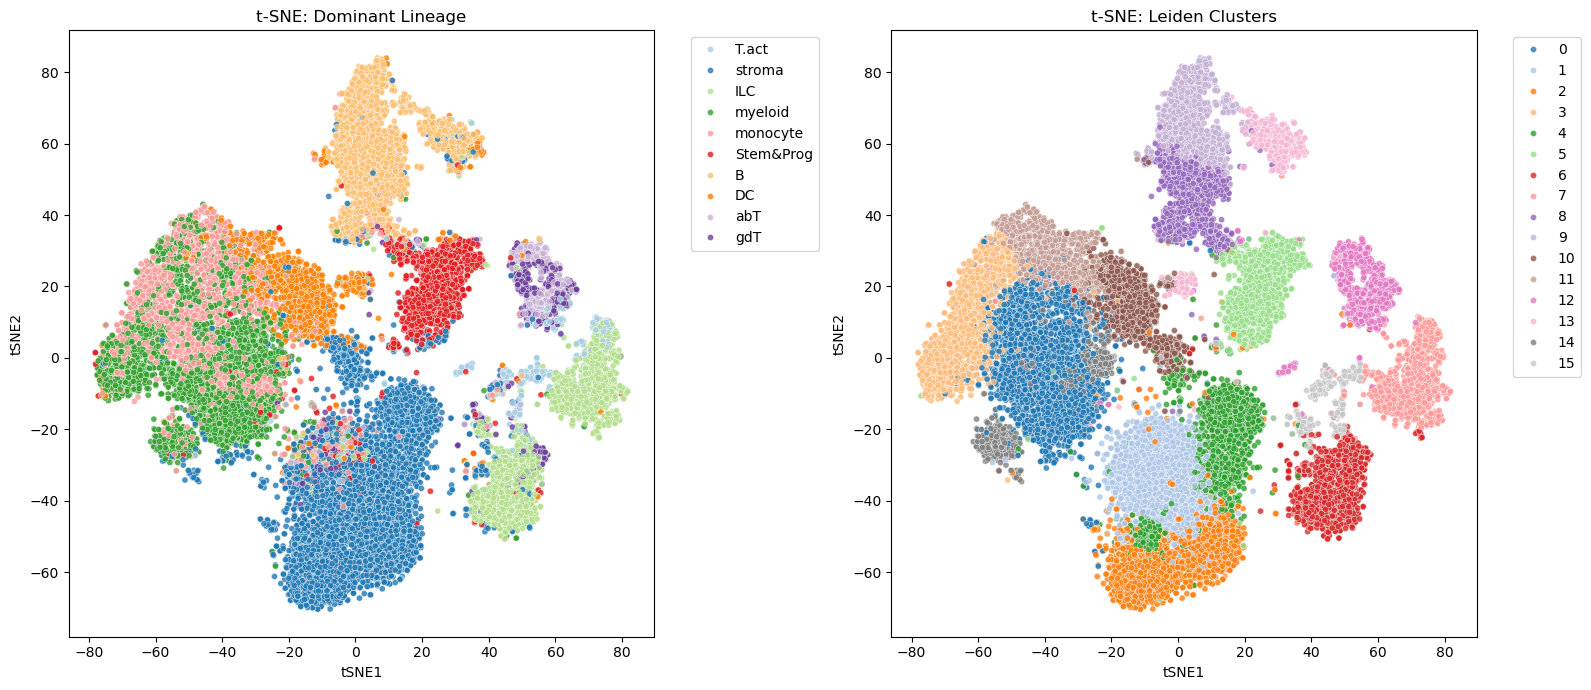

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Dominant Lineage Plot
sns.scatterplot(
    data=tsne_df,
    x='tSNE1', y='tSNE2',
    hue='dominant_lineage',
    palette='Paired',
    alpha=0.8,
    s=20,
    ax=axes[0]
)
axes[0].set_title("t-SNE: Dominant Lineage")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Leiden Cluster Plot
sns.scatterplot(
    data=tsne_df,
    x='tSNE1', y='tSNE2',
    hue='leiden_cluster',
    palette='tab20',
    alpha=0.8,
    s=20,
    ax=axes[1]
)
axes[1].set_title("t-SNE: Leiden Clusters")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('peak_tSNE_comparison_leiden_domlin.png', bbox_inches='tight')
plt.show()


#### NMI and ARI comparison of clusters

In [20]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Ensure both series are aligned
ari = adjusted_rand_score(tsne_df['dominant_lineage'], tsne_df['leiden_cluster'])
nmi = normalized_mutual_info_score(tsne_df['dominant_lineage'], tsne_df['leiden_cluster'])

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")


Adjusted Rand Index (ARI): 0.376
Normalized Mutual Information (NMI): 0.580


#### Confusion Matrix

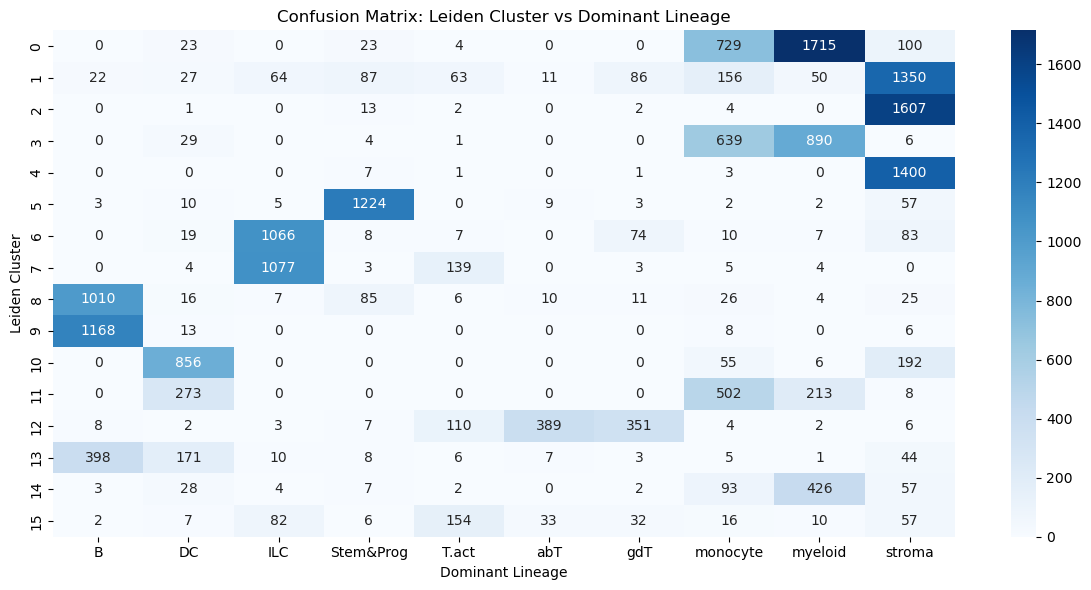

In [21]:
conf_mat = pd.crosstab(tsne_df['leiden_cluster'], tsne_df['dominant_lineage'])

plt.figure(figsize=(12, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Leiden Cluster vs Dominant Lineage")
plt.xlabel("Dominant Lineage")
plt.ylabel("Leiden Cluster")
plt.tight_layout()
plt.savefig('peaks_conf_leiden_domlin.png', bbox_inches='tight')
plt.show()


### t sne of subset

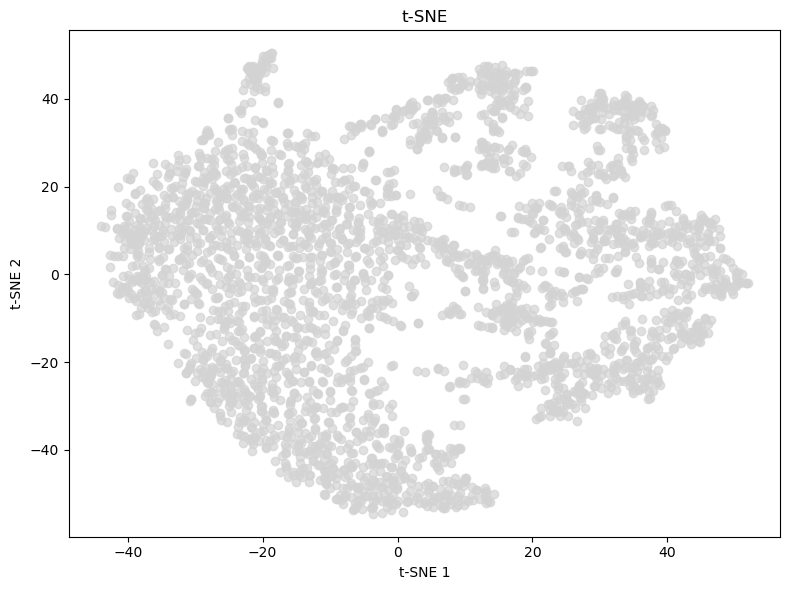

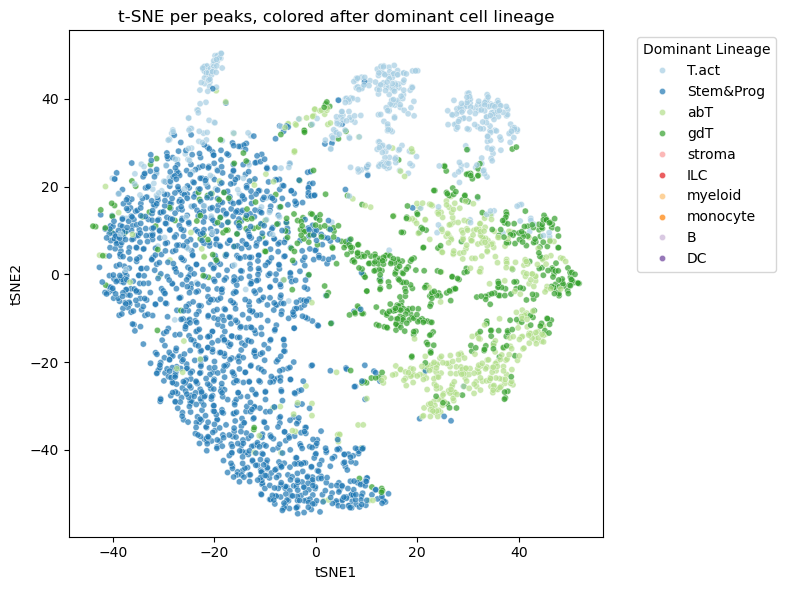

In [22]:
ATAC_dis_sub = ATAC_dis[ATAC_dis['dominant_lineage'].isin(['abT', 'gdT', 'T.act', 'Stem&Prog'])].copy()
top_peaks_idx_sub = [idx for idx in top_peaks_idx if idx in ATAC_dis_sub.index]
score_cols_Tc_all = data['list_ATAC_diff_Tc_all']
coords_sub, gini_sc_sub = functions.tSNE(ATAC_dis_sub, score_cols_Tc_all, 25, 30, top_peaks_idx_sub)

tsne_df_sub = pd.concat([coords_sub, dominant_lineage], axis=1) 

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tsne_df_sub,
    x='tSNE1', y='tSNE2',
    hue='dominant_lineage',
    palette='Paired',
    alpha=0.7,
    s=20
)
plt.title('t-SNE per peaks, colored after dominant cell lineage')
plt.legend(title='Dominant Lineage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Visible clusters of T act and Stem and Progenitor Cells. Different groupings of ab and gd T cells within cluster.

In [24]:
tsne_df['leiden_cluster']

ImmGenATAC1219.peakID
ImmGenATAC1219.peak_506421    12
ImmGenATAC1219.peak_506418    12
ImmGenATAC1219.peak_506420    12
ImmGenATAC1219.peak_504950    12
ImmGenATAC1219.peak_459379     1
                              ..
ImmGenATAC1219.peak_142109     7
ImmGenATAC1219.peak_98031      0
ImmGenATAC1219.peak_104875     0
ImmGenATAC1219.peak_39937      3
ImmGenATAC1219.peak_81360     13
Name: leiden_cluster, Length: 20000, dtype: int64

In [26]:
#add leiden clusters to ATAC_dis

ATAC_dis['leiden_cluster_peaks'] = tsne_df['leiden_cluster']

In [27]:
ATAC_dis

chrom    Summit  mm10.60way.phastCons_scores  \
ImmGenATAC1219.peakID                                                     
ImmGenATAC1219.peak_1       chr1   3020786                         0.00   
ImmGenATAC1219.peak_2       chr1   3087226                         0.00   
ImmGenATAC1219.peak_3       chr1   3120109                         0.07   
ImmGenATAC1219.peak_4       chr1   3121485                         0.15   
ImmGenATAC1219.peak_5       chr1   3372787                         0.03   
...                          ...       ...                          ...   
ImmGenATAC1219.peak_512591  chrY  90812450                         0.00   
ImmGenATAC1219.peak_512592  chrY  90812906                         0.00   
ImmGenATAC1219.peak_512593  chrY  90813175                         0.00   
ImmGenATAC1219.peak_512594  chrY  90813624                         0.00   
ImmGenATAC1219.peak_512595  chrY  90828985                         0.00   

                            _-log10_bestPvalue  \
ImmGenATAC1219.peakID                            
ImmGenATAC1219.peak_1                     0.56   
ImmGenATAC1219.peak_2                     0.50   
ImmGenATAC1219.peak_3                    10.80   
ImmGenATAC1219.peak_4                     3.02   
ImmGenATAC1219.peak_5                     1.31   
...                                        ...   
ImmGenATAC1219.peak_512591                3.99   
ImmGenATAC1219.peak_512592                3.21   
ImmGenATAC1219.peak_512593                0.69   
ImmGenATAC1219.peak_512594                0.60   
ImmGenATAC1219.peak_512595                1.41   

                            Included.in.systematic.analysis  TSS  \
ImmGenATAC1219.peakID                                              
ImmGenATAC1219.peak_1                                   NaN  NaN   
ImmGenATAC1219.peak_2                                   NaN  NaN   
ImmGenATAC1219.peak_3                                   1.0  NaN   
ImmGenATAC1219.peak_4                                   1.0  NaN   
ImmGenATAC1219.peak_5                                   NaN  NaN   
...                                                     ...  ...   
ImmGenATAC1219.peak_512591                              1.0  NaN   
ImmGenATAC1219.peak_512592                              1.0  NaN   
ImmGenATAC1219.peak_512593                              NaN  NaN   
ImmGenATAC1219.peak_512594                              NaN  NaN   
ImmGenATAC1219.peak_512595                              NaN  NaN   

                           genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  \
ImmGenATAC1219.peakID                                                       
ImmGenATAC1219.peak_1                     NaN      0.271312      0.428712   
ImmGenATAC1219.peak_2                     NaN      0.271312      0.847423   
ImmGenATAC1219.peak_3                     NaN      1.131567      0.068653   
ImmGenATAC1219.peak_4                     NaN      0.271312      0.068653   
ImmGenATAC1219.peak_5                     NaN      0.271312      0.068653   
...                                       ...           ...           ...   
ImmGenATAC1219.peak_512591              Erdr1      1.680462      2.401623   
ImmGenATAC1219.peak_512592              Erdr1      0.271312      2.205206   
ImmGenATAC1219.peak_512593              Erdr1      0.271312      0.428712   
ImmGenATAC1219.peak_512594              Erdr1      0.271312      0.847423   
ImmGenATAC1219.peak_512595              Erdr1      0.271312      0.428712   

                            STHSC.150-.BM  ...       min       max     range  \
ImmGenATAC1219.peakID                      ...                                 
ImmGenATAC1219.peak_1            0.525201  ...  0.068554  1.826570  1.758017   
ImmGenATAC1219.peak_2            0.525201  ...  0.068630  1.541715  1.473084   
ImmGenATAC1219.peak_3            0.525201  ...  0.068626  4.997333  4.928707   
ImmGenATAC1219.peak_4            0.075426  ...  0.068653  2.924184  2.855531   
ImmGenATAC1219.peak_5            

### Clustering and comparison of subset

### subset ab gd T cells

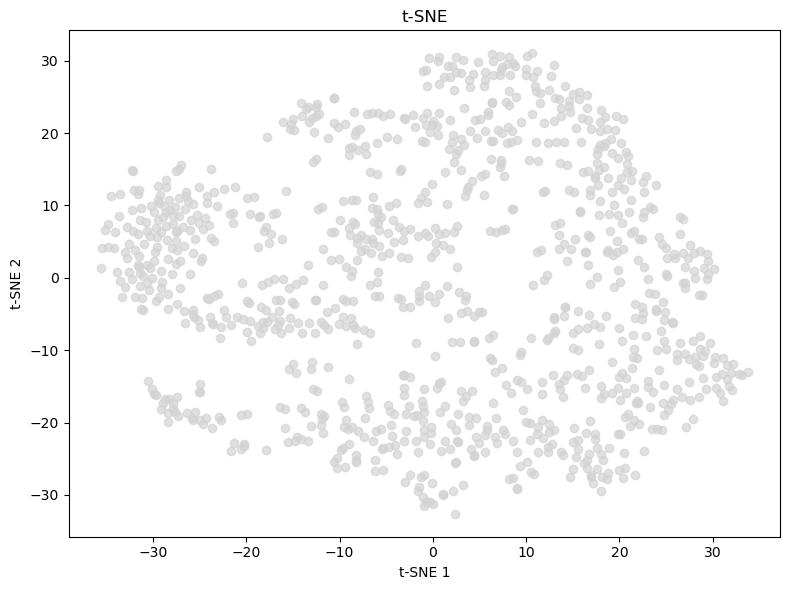

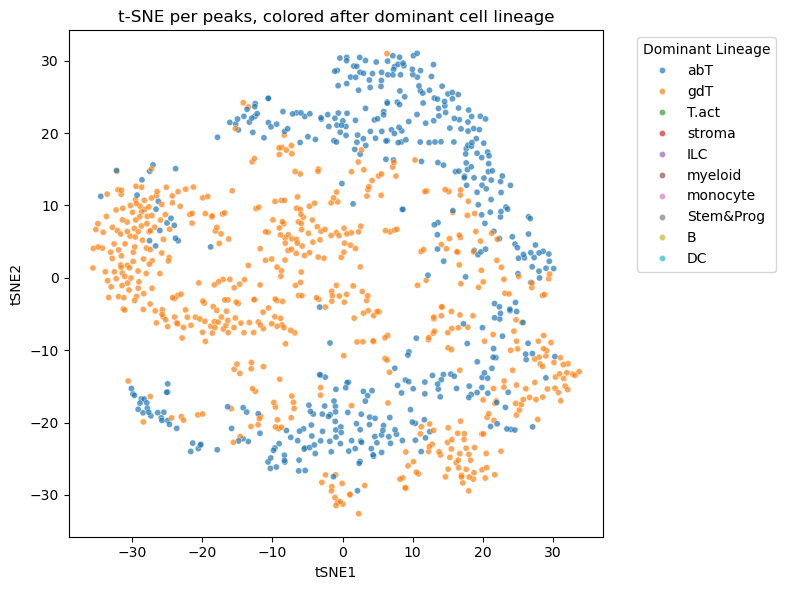

In [23]:
ATAC_dis_sub2 = ATAC_dis[ATAC_dis['dominant_lineage'].isin(['abT', 'gdT'])].copy()
top_peaks_idx_sub2 = [idx for idx in top_peaks_idx if idx in ATAC_dis_sub2.index]
score_cols_Tc_abgd = data['list_ATAC_Tc_ab_gd']
coords_sub2, gini_sc_sub2 = functions.tSNE(ATAC_dis_sub2, score_cols_Tc_abgd, 25, 30, top_peaks_idx_sub2)

tsne_df_sub2 = pd.concat([coords_sub2, dominant_lineage], axis=1) 

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tsne_df_sub2,
    x='tSNE1', y='tSNE2',
    hue='dominant_lineage',
    palette='tab10',
    alpha=0.7,
    s=20
)
plt.title('t-SNE per peaks, colored after dominant cell lineage')
plt.legend(title='Dominant Lineage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()